In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pyGMs as gm
import pyGMs.ising
import pyGMs.wmb

%matplotlib inline


# Download Dataset

In [ ]:
import zipfile
import urllib.request
import os
import pandas as pd

# -------- Step 1: Download and unzip the dataset --------
dataset_url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
zip_path = 'ml-100k.zip'
extract_folder = 'ml-100k'

if not os.path.exists(extract_folder):
    print("Downloading dataset...")
    urllib.request.urlretrieve(dataset_url, zip_path)

    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()
    print("Dataset downloaded and extracted.")
else:
    print("Dataset already exists.")

# -------- Step 2: Read movie metadata from u.item --------
movie_cols = [
    'movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url'
] + [f'genre_{i}' for i in range(19)]

movies_path = os.path.join(extract_folder, 'u.item')

movies = pd.read_csv(
    movies_path,
    sep='|',
    encoding='latin-1',
    header=None,
    names=movie_cols,
    usecols=[0, 1, 2]
)

# -------- Step 3: Display some info --------
print("\n📽️ First 5 Movies:")
print(movies.head())

print(f"\nTotal number of movies: {len(movies)}")


In [62]:
# Load raw MovieLens 100k ratings
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Limit to most active users and most rated movies (e.g., 500 users, 10 movies)
user_counts = ratings['user_id'].value_counts()
movie_counts = ratings['movie_id'].value_counts()

top_users = user_counts.head(500).index
top_movies = movie_counts.head(10).index

filtered = ratings[(ratings['user_id'].isin(top_users)) & (ratings['movie_id'].isin(top_movies))]

# Pivot to user-movie matrix
pivot = filtered.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
X = (pivot >= 4).astype(int).to_numpy()

# Original pivoted binary matrix
X_full = (pivot >= 4).astype(int).to_numpy()

# Shrink: randomly sample, say, 50 users
np.random.seed(42)
sample_indices = np.random.choice(X_full.shape[0], size=50, replace=False)
X_small = X_full[sample_indices]

# Optionally, reduce number of movies too (e.g., first 5 movies)
X_small = X_small[:, :5]



In [63]:
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', header=None, usecols=[0, 1], names=['movie_id', 'title'])
id_to_title = dict(zip(movies['movie_id'], movies['title']))
short = {i: id_to_title[mid] for i, mid in enumerate(pivot.columns)}



In [64]:
# Xtr, Xte = train_test_split(X, test_size=0.2, random_state=42)
Xtr, Xte = train_test_split(X_small, test_size=0.2, random_state=1)



In [65]:
pXi = np.mean(Xtr, axis=0)
model0 = gm.GraphModel([gm.Factor([gm.Var(i, 2)], [1 - pXi[i], pXi[i]]) for i in range(Xtr.shape[1])])

print("Independent model Train LL:", np.mean([model0.logValue(x) for x in Xtr]))
print("Independent model Test  LL:", np.mean([model0.logValue(x) for x in Xte]))


Independent model Train LL: -3.1238857069862243
Independent model Test  LL: -3.4833400772998457


In [66]:
C = 0.5  # Regularization strength

nMovies = Xtr.shape[1]  # Use training set shape, not original X

nbrs, th_ij, th_i = [None] * nMovies, [None] * nMovies, np.zeros((nMovies,))
Xtmp = np.copy(Xtr)

for i in range(nMovies):
    Xtmp[:, i] = 0.  # temporarily remove column i from input
    lr = LogisticRegression(penalty='l1', C=C, solver='liblinear').fit(Xtmp, Xtr[:, i])
    nbrs[i] = np.where(np.abs(lr.coef_) > 1e-6)[1]
    th_ij[i] = lr.coef_[0, nbrs[i]] / 2.
    th_i[i] = lr.intercept_ / 2.
    Xtmp[:, i] = Xtr[:, i]  # restore column i

print("Average connectivity at C =", C, ":", np.mean([len(nn) for nn in nbrs]), "+/-", np.std([len(nn) for nn in nbrs]))


Average connectivity at C = 0.5 : 1.2 +/- 0.7483314773547883


/var/folders/dd/mj_wq35n4yxbxcg8pvwwyrx00000gn/T/ipykernel_72484/2508877422.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  th_i[i] = lr.intercept_ / 2.
/var/folders/dd/mj_wq35n4yxbxcg8pvwwyrx00000gn/T/ipykernel_72484/2508877422.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  th_i[i] = lr.intercept_ / 2.
/var/folders/dd/mj_wq35n4yxbxcg8pvwwyrx00000gn/T/ipykernel_72484/2508877422.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  th_i[i] = lr.intercept_ 

{0: 'Movie Toy Story (1995)', 1: 'Movie Star Wars (1977)', 2: 'Movie Fargo (1996)', 3: 'Movie Independence Day (ID4) (1996)', 4: 'Movie Return of the Jedi (1983)'}
{0: 'Movie Toy Story (1995)', 1: 'Movie Star Wars (1977)', 2: 'Movie Fargo (1996)', 3: 'Movie Independence Day (ID4) (1996)', 4: 'Movie Return of the Jedi (1983)'}


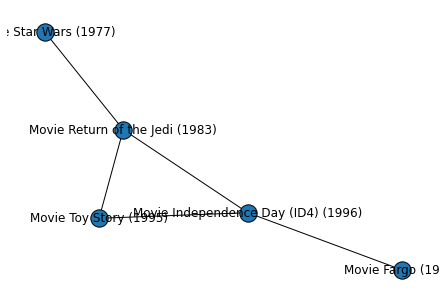

In [71]:
factors = [gm.Factor(gm.Var(i, 2), [-t, t]).exp() for i, t in enumerate(th_i)]
for i in range(nMovies):
    for j, n in enumerate(nbrs[i]):
        scope = [gm.Var(i, 2), gm.Var(int(n), 2)]
        t = th_ij[i][j]
        factors.append(gm.Factor(scope, [[t, -t], [-t, t]]).exp())

model1 = gm.GraphModel(factors)
model1.makeMinimal()
titles = short.copy()
print(titles)
short = {var.label: f"{titles[var.label]}" for var in model1.vars}
print(short)


gm.drawMarkovGraph(model1, labels=short)


In [36]:
order, _ = gm.eliminationOrder(model1, 'minfill')
jt = gm.wmb.JTree(model1, elimOrder=order)
lnZ = jt.msgForward()

print("Log partition function:", lnZ)
print("Ising Train LL:", np.mean([model1.logValue(x) for x in Xtr]) - lnZ)
print("Ising Test LL:", np.mean([model1.logValue(x) for x in Xte]) - lnZ)


Log partition function: 4.613474848461795
Ising Train LL: -3.191139536376672
Ising Test LL: -3.8993778691343284


In [74]:
def conditional(factor, i, x):
    return factor.t[tuple(x[v] if v != i else slice(v.states) for v in factor.vars)]

def pseudolikelihood(model, X):
    LL = np.zeros(X.shape)
    for i in range(X.shape[1]):  # for each variable (movie)
        flist = model.factorsWith(i, copy=False)
        for j in range(X.shape[0]):  # for each data point (user)
            pXi = 1.
            for f in flist:
                pXi *= conditional(f, i, X[j])
            LL[j, i] = np.log(pXi[X[j, i]] / pXi.sum())
    return LL.sum(1)


In [75]:
print("Pseudo-likelihood (Train):", pseudolikelihood(model1, Xtr).mean())
print("Pseudo-likelihood (Test):", pseudolikelihood(model1, Xte).mean())


Pseudo-likelihood (Train): -2.937699058695827
Pseudo-likelihood (Test): -4.350596218818228
